In [ ]:
!pip install astroquery

     |████████████████████████████████| 4.5 MB 16.0 MB/s 
     |████████████████████████████████| 802 kB 66.0 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 3.6 MB 68.3 MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=632eff00180e3964708cd3a3ca474db029bfb67d9c279e6e30ac099d9309eec3
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
Successfully built mimeparse


In [ ]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt

In [ ]:
# make sure we grab as many entries as possible
Gaia.ROW_LIMIT = -1

In [ ]:
# grab gmag information from all EDR3 entries
job = Gaia.launch_job_async("select phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_mag, phot_g_n_obs"
"                            from gaiaedr3.gaia_source")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
gmagFlux = r['phot_g_mean_flux']
gmagFluxErr = r['phot_g_mean_flux_error']
gmag = r['phot_g_mean_mag']
gmagNobs = r['phot_g_n_obs']

In [ ]:
# find the zero point reference conversion between magnitude and flux
zp = gmag + 2.5*np.log10(gmagFlux) 
zp = np.mean(zp)

In [ ]:
# converting "good" magnitude range into flux range
gL, gU = 13, 18
gFL, gFU = 10**((zp - gL) / 2.5), 10**((zp - gU) / 2.5)

In [ ]:
# create filter to grab only good magnitude values
gRange_mask = np.where(gmag > gL) and np.where(gmag < gU)

gmagFlux = gmagFlux[gRange_mask]
gmagFluxErr = gmagFluxErr[gRange_mask]
gmag = gmag[gRange_mask]
gmagNobs = gmagNobs[gRange_mask]


In [ ]:
# error on magnitude based on flux error
gmagErr = (-2.5/np.log(10)) * gmagFluxErr / gmagFlux

# expected flux error based on poisson dist and number of obervations
expectedFluxErr = np.sqrt(gmagFlux) / np.sqrt(gmagNobs)

# expected magnitude error based on the expected flux error
expectedgmagErr = (-2.5/np.log(10)) * expectedFluxErr / gmagFlux

# expected magnitude error based poisson
expectedPoissonGmagErr = (2.5/np.log(10)) * np.sqrt(gmagFlux) / gmagFlux

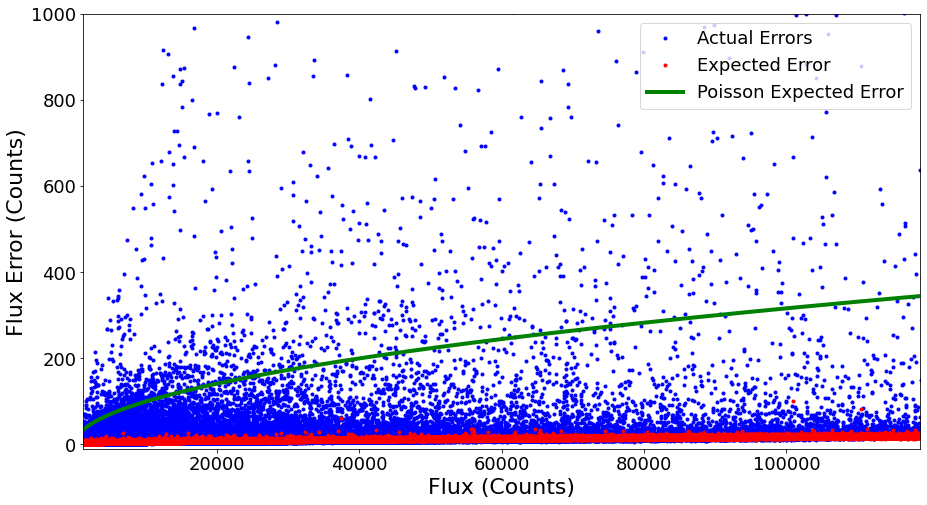

In [ ]:
# # looking at magnitude error vs expected error
# figure = plt.figure(figsize=(15,8))
# testRange = np.arange(gFU, gFL)
# testErr = (2.5/np.log(10)) * np.sqrt(testRange) / testRange
# testRange = np.arange(gL, gU, (gU-gL)/len(testRange))
# plt.plot(abs(gmag), abs(gmagErr), 'b.', label = 'Recorded Error')
# plt.plot(abs(gmag), abs(expectedgmagErr), 'r.', label = 'Expected Error')
# plt.plot(testRange, testErr, 'green', linewidth = 3, label = 'Poisson Expected Error')
# plt.xlim(gL,gU)
# plt.ylim(top=.15)
# plt.xlabel('G_mag', fontsize = 15)
# plt.ylabel('G_mag Error', fontsize = 15)
# plt.legend(fontsize = 15)
# plt.xticks(fontsize = 12 )
# plt.yticks(fontsize = 12)
# plt.show()


# looking at flux error vs expected flux error
testRange = np.arange(gFU, gFL)
figure = plt.figure(figsize=(15,8))
plt.plot(gmagFlux, gmagFluxErr, 'b.', label = 'Actual Errors')
plt.plot(gmagFlux, expectedFluxErr, 'r.', label = 'Expected Error') # expected due to error due to poisson & num obs
plt.plot(testRange, np.sqrt(testRange), 'green', linewidth = 4, label = 'Poisson Expected Error') # error due to poisson only
plt.xlim(gFU, gFL)
plt.ylim(-10, 1000)
plt.xlabel('Flux (Counts)', fontsize = 22)
plt.ylabel('Flux Error (Counts)', fontsize = 22)
plt.legend(fontsize = 18)
plt.xticks(fontsize = 18 )
plt.yticks(fontsize = 18)
plt.savefig('VgCals.png', bbox_inches='tight')
plt.show()


In [ ]:
youngExpected = np.asarray(expectedFluxErr < gmagFluxErr)
youngExpectedStrongCut = np.asarray(np.sqrt(gmagFlux) < gmagFluxErr)

In [ ]:
c = 0
cStrong = 0
for y in youngExpected:
  if y: c += 1

for y in youngExpectedStrongCut:
  if y: cStrong += 1

print(f'Number of High Variable Stars: {c}')
print(f'Concentration of High Variable Stars: {c / len(youngExpected)}')

print(f'Number of Highly Variable Stars: {cStrong}')
print(f'Concentration of Highly Variable Stars: {cStrong / len(youngExpectedStrongCut)}')

Number of High Variable Stars: 122319
Concentration of High Variable Stars: 0.24492603301482543
Number of Highly Variable Stars: 1979
Concentration of Highly Variable Stars: 0.003962660088263798


---

Here, we looked at the two different magnitude variability cuts we had available: we could cut based on expected flux error due to only the poisson distribution error (the stronger cut) or by also taking into account the number of observations (looser cut). Both cases, we look for actual errors that were greater than our cut, indicating there was some form of unaccounted error, possibly indicating a highly variable star. We can both cuts in our random forest -- we can start with the broad cut and feed into the stricter cut.

---